In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel, pipeline 
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
## Exercise 1: Basic Sentiment Analysis
##Extend the starter code to:
##1. Create positive/negative labels based on ratings (>3 = positive, <3 = negative)
##2. Split data into train/test sets
##3. Calculate average embeddings for positive and negative classes
##4. Classify new reviews based on closest average embedding
##5. Calculate accuracy

#code from sentiment-analysis provided by prof:
class ReviewAnalyzer:
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.eval()
    
    def get_embeddings(self, texts): #takes in a list of text data (reviews) and generates embeddings
        """Generate embeddings for a list of texts."""
        encoded = self.tokenizer( #tokenizes (converts to smaller units) the input texts
            texts,
            padding=True, #ensures all texts are same length
            truncation=True, #ensures all texts are same length (cuts longer texts to 128 units)
            max_length=128,
            return_tensors="pt" #specifies that the output should be in Pytorch tensor format
        )
        
        with torch.no_grad():
            output = self.model(**encoded) #passes tokenized input through pre-trained model to get output
                #output = embeddings for each token in the sentence
            embeddings = self._mean_pooling(output, encoded['attention_mask']) # Use mean pooling to get sentence embeddings
                #converts token embeddings into single sentence-level embedding
                #calling _mean_pooling (defined below) to perform this step
        return embeddings
    
    def _mean_pooling(self, model_output, attention_mask):
        #computs the sentence embeddings by averaging token embeddings, weighted by the attention mask
        token_embeddings = model_output[0] #extracts token embeddings from models output
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(
            token_embeddings.size()).float() #expands attention mask to match the dimensions of the token embeddings
        return torch.sum(token_embeddings * input_mask_expanded, 1) / \
               torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                #numerator computes weighted sum of the token embeddings (ignoring padding tokens)
                #denominator ensures we don't divide by 0 by clamping the sump of attention mask to min value

Creating initial sentiment classifier with one train_test_split. This is my first analysis on the supplemented dataset in which I added more reviews that I generated from Chat GPT. Results can be analyzed through the accuracy score, confusion matrix, and ROC-AUC score.

In [3]:
def create_sentiment_classifier(df,embeddings, ratings):
    #Normalizing Data
    embeddings = normalize(embeddings, norm="l2")
    # Create labels
    labels = (ratings > 3).astype(int)

     # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2
    )

    #Calculate Class Averages
    avg_positive = np.mean(X_train[y_train.astype(bool)], axis=0)
    avg_negative = np.mean(X_train[~y_train.astype(bool)], axis=0)


    #Classification function$
    def classifier(review_embedding):
        positive_similarity = cosine_similarity([review_embedding],[avg_positive])[0][0]
        negative_similarity = cosine_similarity([review_embedding], [avg_negative])[0][0]
        return 1 if positive_similarity > negative_similarity else 0
    
    #Accuracy Scores
    predictions = np.array([classifier(e) for e in X_test])
    accuracy = np.mean(predictions == y_test)
    print(f"Accuracy: {accuracy}")

    #Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    #Roc-auc score:
    roc_auc = roc_auc_score(y_test, predictions)
    print(f"ROC-AUC Score: {roc_auc}")

    #Print example predictions from the test set
    print("Test_Set Predictions")
    for i in range(5):  # Print 5 test set predictions
        print(f"Review {i+1}: {df['review_text'].iloc[i]}")
        print(f"Actual Sentiment: {'Positive' if y_test[i] == 1 else 'Negative'}")
        print(f"Predicted Sentiment: {'Positive' if predictions[i] == 1 else 'Negative'}\n")

    return classifier



In [4]:
def run_sentiment_analysis():
    # Load dataset
    df = pd.read_csv("amazon_reviews_1.csv")

    # Extract text and ratings
    review_texts = df["review_text"].tolist()
    ratings = df["rating"].values

    # Initialize analyzer and generate embeddings
    analyzer = ReviewAnalyzer()
    embeddings = analyzer.get_embeddings(review_texts).numpy()  # Convert to NumPy

    # Train sentiment classifier
    classifier = create_sentiment_classifier(df,embeddings, ratings)

    # Test classifier on new reviews
    test_reviews = [
        "This product exceeded my expectations!",
        "Not happy with the purchase at all.",
        "boo I hate this",
        "Omg love it!",
        "This product was okay"
    ]
    test_embeddings = analyzer.get_embeddings(test_reviews).numpy()

    print("New Review Predictions:")
    for i, review in enumerate(test_reviews):
        sentiment = classifier(test_embeddings[i])
        sentiment_label = "Positive" if sentiment == 1 else "Negative"
        print(f"Review: {review}\nPredicted Sentiment: {sentiment_label}\n")

Testing the centroid-based approach with k-fold cross validation instead of a single train_test_split

In [5]:
# Cross-Validation with Centroids
def create_sentiment_classifier_cv(df, embeddings, ratings, k_folds=5):

    #Normalizing Data
    embeddings = normalize(embeddings, norm="l2")
    
    # Create labels
    labels = (ratings > 3).astype(int)  # 1 for Positive, 0 for Negative

    # Initialize K-Fold Cross-Validation
    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    all_y_true = []  # Store true labels
    all_y_pred = []  # Store predicted labels
    fold_accuracies = []  # Store accuracy per fold

    for train_idx, test_idx in kfold.split(embeddings, labels):

        X_train, X_test = embeddings[train_idx], embeddings[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        avg_positive = np.mean(X_train[y_train.astype(bool)], axis=0)
        avg_negative = np.mean(X_train[~y_train.astype(bool)], axis=0)

        def classifier_cv(review_embedding):
            pos_sim = cosine_similarity([review_embedding], [avg_positive])[0][0]
            neg_sim = cosine_similarity([review_embedding], [avg_negative])[0][0]
    
            if pos_sim > neg_sim:
                return 1  # Positive
            elif neg_sim > pos_sim:
                return 0  # Negative
            else:
                return np.random.choice([0, 1])  # Break ties randomly


        y_pred = np.array([classifier_cv(e) for e in X_test])

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        fold_accuracies.append(accuracy_score(y_test, y_pred))

    # 8. Compute Final Metrics Across All Folds
    final_accuracy = np.mean(fold_accuracies)
    final_std = np.std(fold_accuracies)
    final_conf_matrix = confusion_matrix(all_y_true, all_y_pred)
    final_roc_auc = roc_auc_score(all_y_true, all_y_pred)

    # 9. Print Results
    print(f"Cross-Validation Results for Centroid-Based Classification:")
    print(f"Mean Accuracy: {final_accuracy:.4f}")
    print(f"Standard Deviation: {final_std:.4f}")
    print(f"ROC-AUC Score: {final_roc_auc:.4f}")

    # 10. Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(final_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Centroid-Based Classification")
    plt.show()

    return classifier_cv  



In [6]:
def run_sentiment_analysis_cv():
    # Load dataset
    df = pd.read_csv("amazon_reviews_1.csv")

    # Extract text and ratings
    review_texts = df["review_text"].tolist()
    ratings = df["rating"].values

    # Initialize analyzer and generate embeddings
    analyzer = ReviewAnalyzer()
    embeddings = analyzer.get_embeddings(review_texts).numpy()  # Convert to NumPy

    # Train sentiment classifier using cross-validation
    classifier_cv = create_sentiment_classifier_cv(df, embeddings, ratings, k_folds=5)

    # Test classifier on new reviews
    test_reviews = [
        "This product exceeded my expectations!",
        "Not happy with the purchase at all.",
        "boo I hate this",
        "Omg love it!",
        "This product was okay"
    ]
    test_embeddings = analyzer.get_embeddings(test_reviews).numpy()

    print("New Review Predictions:")
    for i, review in enumerate(test_reviews):
        sentiment = classifier_cv(test_embeddings[i])  # Use the trained classifier
        sentiment_label = "Positive" if sentiment == 1 else "Negative"
        print(f"Review: {review}\nPredicted Sentiment: {sentiment_label}\n")

Now implementing cross validation with a classifier approach instead of a centroid.

In [7]:
def perform_cross_validation(df, classifier_choice="logistic"):

    #Extract text and ratings
    review_texts = df["review_text"].tolist()
    ratings = df["rating"].values
    labels = (ratings > 3).astype(int)  # 1 for Positive, 0 for Negative

    #Generate embeddings
    analyzer = ReviewAnalyzer()
    embeddings = analyzer.get_embeddings(review_texts).numpy()

    #Standardize for logistic regression
    scaler = StandardScaler()
    embeddings = scaler.fit_transform(embeddings)
    
    classifiers = {
        "logistic": LogisticRegression(),
    }

    model = classifiers[classifier_choice]

   #Cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    predictions = cross_val_predict(model, embeddings, labels, cv=kfold)

    #results
    accuracy = accuracy_score(labels, predictions)
    roc_auc = roc_auc_score(labels, predictions)
    cm = confusion_matrix(labels, predictions)

    print(f"Cross-Validation Results for {classifier_choice.capitalize()} Classifier:")
    print(f"Mean Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    # 6. Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {classifier_choice.capitalize()} Classifier")
    plt.show()

    #Return the trained model (last trained fold)
    model.fit(embeddings, labels)  
    return model, accuracy

Sentiment Analysis with Single Train-Test Split:
Accuracy: 0.8571428571428571


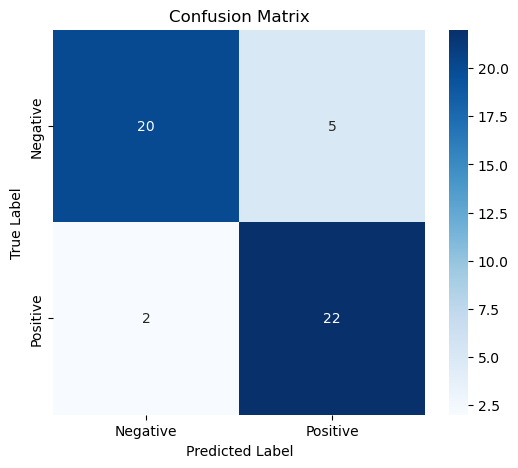

ROC-AUC Score: 0.8583333333333333
Test_Set Predictions
Review 1: This laptop is amazing! The battery life is incredible and the display is crystal clear.
Actual Sentiment: Negative
Predicted Sentiment: Negative

Review 2: Decent product but overpriced. Build quality could be better.
Actual Sentiment: Negative
Predicted Sentiment: Positive

Review 3: Terrible experience. Stopped working after two weeks.
Actual Sentiment: Positive
Predicted Sentiment: Positive

Review 4: Great phone, fast charging and amazing camera quality!
Actual Sentiment: Negative
Predicted Sentiment: Negative

Review 5: Good but not great. The camera is excellent but battery life is mediocre.
Actual Sentiment: Positive
Predicted Sentiment: Positive

New Review Predictions:
Review: This product exceeded my expectations!
Predicted Sentiment: Positive

Review: Not happy with the purchase at all.
Predicted Sentiment: Negative

Review: boo I hate this
Predicted Sentiment: Negative

Review: Omg love it!
Predicted Sentimen

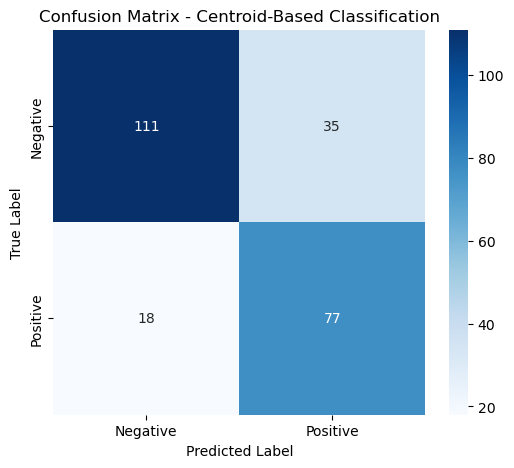

New Review Predictions:
Review: This product exceeded my expectations!
Predicted Sentiment: Positive

Review: Not happy with the purchase at all.
Predicted Sentiment: Positive

Review: boo I hate this
Predicted Sentiment: Negative

Review: Omg love it!
Predicted Sentiment: Positive

Review: This product was okay
Predicted Sentiment: Positive

Logistic Regression Cross-Validation:
Cross-Validation Results for Logistic Classifier:
Mean Accuracy: 0.8797
ROC-AUC Score: 0.8749


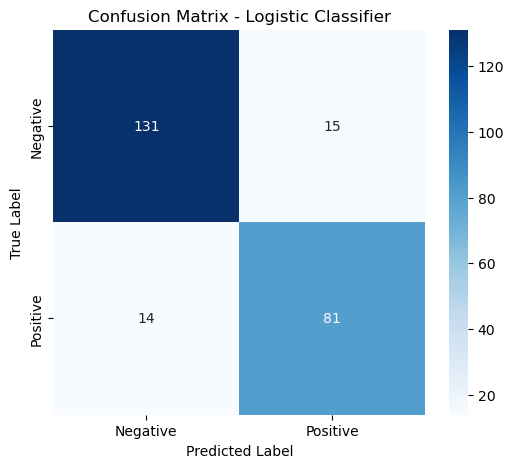

Final Trained Model Accuracy: 0.8797
Predicting New Reviews Using Best Model:
Review: This product exceeded my expectations!
Predicted Sentiment: Negative

Review: Not happy with the purchase at all.
Predicted Sentiment: Negative

Review: Boo, I hate this.
Predicted Sentiment: Negative

Review: Omg love it!
Predicted Sentiment: Positive

Review: This product was okay
Predicted Sentiment: Negative



In [8]:
if __name__ == "__main__":
    df = pd.read_csv("amazon_reviews_1.csv")  # Load dataset

    print("Sentiment Analysis with Single Train-Test Split:")
    run_sentiment_analysis()

    print("Sentiment Analysis with Cross-Validation:")
    run_sentiment_analysis_cv()

    print("Logistic Regression Cross-Validation:")
    best_model, best_accuracy = perform_cross_validation(df, classifier_choice="logistic")
    print(f"Final Trained Model Accuracy: {best_accuracy:.4f}")

    print("Predicting New Reviews Using Best Model:")
    analyzer = ReviewAnalyzer()
    test_reviews = [
        "This product exceeded my expectations!",
        "Not happy with the purchase at all.",
        "Boo, I hate this.",
        "Omg love it!",
        "This product was okay"
    ]

    test_embeddings = analyzer.get_embeddings(test_reviews).numpy()
    predictions = best_model.predict(test_embeddings)  

    for review, pred in zip(test_reviews, predictions):
        sentiment_label = "Positive" if pred == 1 else "Negative"
        print(f"Review: {review}\nPredicted Sentiment: {sentiment_label}\n")
